In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.models import load_model
%matplotlib inline

## About the data
<hr>
For training our models, we will be using the MovieLens 100k dataset by GroupLens. <br><br>
GroupLens Research has collected and made available rating data sets from the MovieLens web site (http://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. 

In [184]:
ratings = pd.read_csv("../data/ml-latest-small/ratings.csv")
movies = pd.read_csv("../data/ml-latest-small/movies.csv", index_col=0)

The contents of the dataset are:

In [7]:
%ls ../data/ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt  tags.csv


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [32]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


We assume that movies above the rating 2.5 are good (the user likes them and is willing to watch other movies of that sort)

In [185]:
good_ratings = ratings[ratings.rating > 2.4]

In [10]:
good_ratings.shape, ratings.shape

((86619, 4), (100004, 4))

In [43]:
good_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
4,1,1172,4.0,1260759205
8,1,1339,3.5,1260759125


### The data

In [39]:
def apply_fun(x):
    x['MovieName'] = movies.title[x.movieId]
    return x

In [60]:
one_user = good_ratings[good_ratings.userId == 1]
one_user['MovieName'] = 'movie'
one_user = one_user.apply(apply_fun, axis=1)
one_user.drop('movieId', axis=1)
one_user.head()

/home/nischal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,userId,movieId,rating,timestamp,MovieName
0,1,31,2.5,1260759144,Dangerous Minds (1995)
1,1,1029,3.0,1260759179,Dumbo (1941)
2,1,1061,3.0,1260759182,Sleepers (1996)
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989)
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992)


In [61]:
one_user.sort_values(by='timestamp').head()

,userId,movieId,rating,timestamp,MovieName
17,1,2455,2.5,1260759113,"Fly, The (1986)"
19,1,3671,3.0,1260759117,Blazing Saddles (1974)
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992)
10,1,1371,2.5,1260759135,Star Trek: The Motion Picture (1979)
13,1,2105,4.0,1260759139,Tron (1982)


Our model should learn such sequences and predict the next movie based on user behaviour.

In [67]:
for mid in one_user.movieId.values[:-1]:
    print("{} -> ".format(mid), end="")
print(one_user.movieId.values[-1])

31 -> 1029 -> 1061 -> 1172 -> 1339 -> 1371 -> 1953 -> 2105 -> 2150 -> 2455 -> 3671


In [190]:
groups = good_ratings.sort_values('timestamp').groupby("userId")
max_length = groups.movieId.count().max()
print(max_length)

1997


Make the training data

In [191]:
train_data = []
train_data = np.concatenate((train_data, 
                             groups
                                .apply(
                                    lambda x: np.concatenate(
                                        (x.movieId.values.tolist(), 
                                         np.zeros(max_length - len(x.movieId.values.tolist())))
                                        )
                                    .reshape((-1, 1))
                                    .tolist()
                                )))
train_data = train_data.tolist()

In [192]:
train_data[0][:10]

[[2455.0],
 [3671.0],
 [1339.0],
 [1371.0],
 [2105.0],
 [31.0],
 [1029.0],
 [1061.0],
 [1953.0],
 [2150.0]]

In [193]:
train_data[1][:10]

[[592.0],
 [296.0],
 [590.0],
 [150.0],
 [588.0],
 [153.0],
 [165.0],
 [349.0],
 [292.0],
 [339.0]]

## Split data into 3 part
<hr>
Now, we split the data into 3 parts, to make mini-batches, so as to learn faster.

In [159]:
d1x, d2x, d3x = pd.split_into_mini_batches(data=train_data, parts=3)

In [160]:
d1x[:15], d2x[:15], d3x[:15]

(array([   4,   14,   32,  137,  143,  151,  157,  174,  227,  293,  440,
         550, 1797]),
 array([  5,  12,  23,  44,  75,  82, 118, 122, 163, 219, 247, 251, 311]),
 array([   6,   50,   59,  162,  238,  239,  242,  602,  780, 1069, 1538,
        1633, 1805]))

## Defining `y` for data 
<hr>
Now that we have our data, we need to specify what the model should learn for each of the input IDs. We create the `y` set by shifting `X` by one to the left and adding the first element of `X` to the end of the `y`. The below is what it should look like.

<table>
    <tr>
        <th>X</th>
        <td>0</td>
        <td>1</td>
        <td>2</td>
        <td>3</td>
        <td>4</td>
        <td>5</td>
        <td>6</td>
        <td>7</td>
        <td>8</td>
        <td>9</td>
    <tr>
        <th>y</th>
        <td>1</td>
        <td>2</td>
        <td>3</td>
        <td>4</td>
        <td>5</td>
        <td>6</td>
        <td>7</td>
        <td>8</td>
        <td>9</td>
        <td>0</td>
    </tr>
</table>

In [161]:
d1y = np.append(d1x[1:], d1x[0])
d2y = np.append(d2x[1:], d2x[0])
d3y = np.append(d3x[1:], d3x[0])

In [162]:
d1x[:10], d1y[:10]

(array([  4,  14,  32, 137, 143, 151, 157, 174, 227, 293]),
 array([ 14,  32, 137, 143, 151, 157, 174, 227, 293, 440]))

## Define RNN arch

Now that the data is preped and ready, we begin designing out RNN. First, we reshape the data to comply with the standard Keras API. 

In [163]:
d1x = d1x.reshape(d1x.shape[0], 1, 1)
d2x = d2x.reshape(d2x.shape[0], 1, 1)
d3x = d3x.reshape(d3x.shape[0], 1, 1)

In [179]:
model = Sequential() 
model.add(GRU(50, batch_input_shape=(1, d1x.shape[1], d1x.shape[2]), 
               stateful=True, return_sequences=True))
model.add(GRU(100, stateful=True, return_sequences=True))
model.add(GRU(300, stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (1, 1, 50)                7800      
_________________________________________________________________
gru_26 (GRU)                 (1, 1, 100)               45300     
_________________________________________________________________
gru_27 (GRU)                 (1, 300)                  360900    
_________________________________________________________________
dense_9 (Dense)              (1, 1)                    301       
Total params: 414,301.0
Trainable params: 414,301
Non-trainable params: 0.0
_________________________________________________________________


### Helper functions

In [123]:
def plot_helper(l, bl, name, save_path):
    x_scale = range(len(l))
    plt.clf()
    plt.figure(figsize=[8, 6])
    plt.subplot(111)
    plt.plot(x_scale, l, 'y-', label='Loss')
    plt.plot(x_scale, bl, 'r-', label='Best Loss')
    plt.title('Loss and Best Loss for ' + name, fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.savefig(save_path)

In [58]:
def train_helper(model, X, y, epochs, log_at, save_path, epochs_done=0, loss_min=10e10):
    loss_history, best_loss = [], []
    for i in range(epochs + 1):
        h = model.fit(X, y, epochs=1, batch_size=1, shuffle=False, verbose=0)
        model.reset_states()
        curr_loss = h.history['loss'][0]
        if curr_loss < loss_min:
            loss_min = curr_loss
            model.save(save_path)
        loss_history.append(curr_loss)
        best_loss.append(loss_min)
        if i % log_at == 0:
            print("Epoch: {}, current_loss: {}, best_loss: {}".format(i + epochs_done, curr_loss, loss_min))
    return loss_history, best_loss, epochs + epochs_done, loss_min

## Train all 3 batches
### Batch 1 (d1x)

In [59]:
d1x_loss, d1x_best_loss, e_done, min_loss = [], [], 0, 10e10

#### After 1000 epochs

In [60]:
l, bl, e_done, min_loss = train_helper(
    model=model, 
    X=d1x, y=d1y, 
    epochs=1000, log_at=100, epochs_done=e_done,
    loss_min=min_loss,
    save_path="../models/03_arch_d1x")

d1x_loss.extend(l)
d1x_best_loss.extend(bl)

Epoch: 0, current_loss: 290660.20420485275, best_loss: 290660.20420485275
Epoch: 100, current_loss: 216930.5529714731, best_loss: 216930.5529714731
Epoch: 200, current_loss: 192058.25843447447, best_loss: 184884.0793199631
Epoch: 300, current_loss: 165321.97230573342, best_loss: 165321.97230573342
Epoch: 400, current_loss: 154334.8175292812, best_loss: 154072.38076261373
Epoch: 500, current_loss: 145996.34638453735, best_loss: 145996.34638453735
Epoch: 600, current_loss: 140826.02247143709, best_loss: 140779.42039673144
Epoch: 700, current_loss: 142349.84330672486, best_loss: 137177.9705002308
Epoch: 800, current_loss: 133772.6387121815, best_loss: 133772.6387121815
Epoch: 900, current_loss: 145000.62078009473, best_loss: 121494.1971897437
Epoch: 1000, current_loss: 84992.75118533848, best_loss: 84992.75118533848


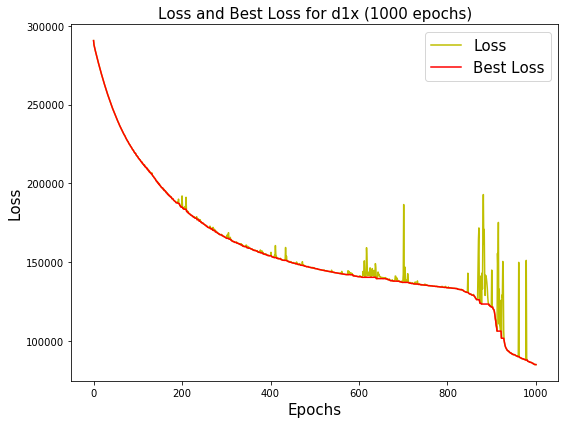

In [124]:
plot_helper(d1x_loss, d1x_best_loss, 'd1x (1000 epochs)', '../figures/d1x_1000.png')

#### After 5000 epochs

In [126]:
l, bl, e_done, min_loss = train_helper(
    model=model, 
    X=d2x, y=d2y, 
    epochs=2500, log_at=100, epochs_done=e_done,
    loss_min=min_loss,
    save_path="../models/03_arch_d1x")

d1x_loss.extend(l)
d1x_best_loss.extend(bl)

Epoch: 2500, current_loss: 118415.86698970429, best_loss: 45574.378104764684
Epoch: 2600, current_loss: 133363.8267443455, best_loss: 45574.378104764684
Epoch: 2700, current_loss: 107889.61807492991, best_loss: 45574.378104764684
Epoch: 2800, current_loss: 37117.66716229815, best_loss: 37117.66716229815
Epoch: 2900, current_loss: 29818.325670122525, best_loss: 29818.325670122525
Epoch: 3000, current_loss: 23598.316199137113, best_loss: 23546.671419973773
Epoch: 3100, current_loss: 19669.831392015403, best_loss: 19669.831392015403
Epoch: 3200, current_loss: 16105.234719207654, best_loss: 15676.48166335546
Epoch: 3300, current_loss: 11590.577664999148, best_loss: 11590.577664999148
Epoch: 3400, current_loss: 7884.830030679703, best_loss: 7884.830030679703
Epoch: 3500, current_loss: 5000.149537468185, best_loss: 4974.781929000657
Epoch: 3600, current_loss: 2669.2114920037297, best_loss: 2662.882315130188
Epoch: 3700, current_loss: 1043.257780073739, best_loss: 1043.257780073739
Epoch: 380

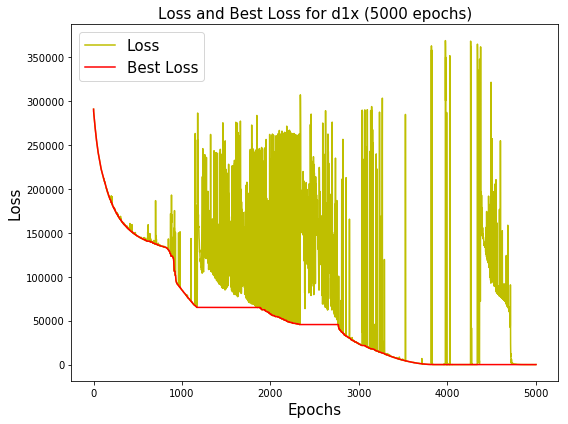

In [127]:
plot_helper(d1x_loss, d1x_best_loss, 'd1x (5000 epochs)', '../figures/d1x_5000.png')

### Batch 2 (d2x)

In [171]:
d2x_loss, d2x_best_loss, d2x_e_done, d2x_min_loss = [], [], 0, 10e10

#### After 1000 epochs

In [172]:
l, bl, d2x_e_done, d2x_min_loss = train_helper(
    model=model, 
    X=d2x, y=d2y, 
    epochs=1000, log_at=100, epochs_done=d2x_e_done,
    loss_min=d2x_min_loss,
    save_path="../models/03_arch_d2x")

d2x_loss.extend(l)
d2x_best_loss.extend(bl)

Epoch: 0, current_loss: 20363.476814856895, best_loss: 20363.476814856895
Epoch: 100, current_loss: 4556.700294604669, best_loss: 4542.56066440619
Epoch: 200, current_loss: 4448.053642878165, best_loss: 4344.086785096389
Epoch: 300, current_loss: 4614.696315040956, best_loss: 4344.086785096389
Epoch: 400, current_loss: 4472.371103946979, best_loss: 4344.086785096389
Epoch: 500, current_loss: 4465.202433952918, best_loss: 4344.086785096389
Epoch: 600, current_loss: 439.71710635721684, best_loss: 439.71710635721684
Epoch: 700, current_loss: 116.4255518592321, best_loss: 105.21092478587077
Epoch: 800, current_loss: 227.41748511676604, best_loss: 35.40824126968017
Epoch: 900, current_loss: 4529.557448590031, best_loss: 35.40824126968017
Epoch: 1000, current_loss: 5106.619009749247, best_loss: 35.40824126968017


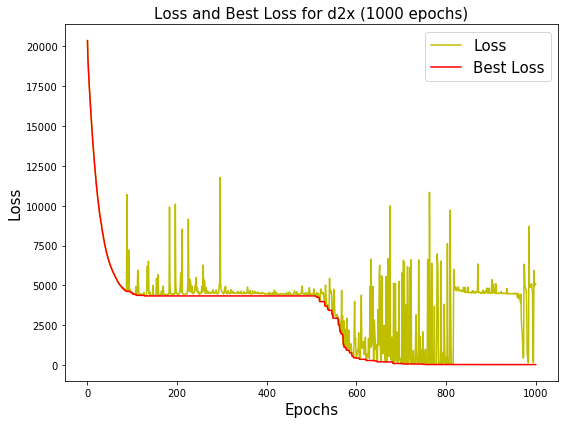

In [173]:
plot_helper(d2x_loss, d2x_best_loss, 'd2x (1000 epochs)', '../figures/d2x_1000.png')

#### After 2500 epochs

In [176]:
l, bl, d2x_e_done, d2x_min_loss = train_helper(
    model=model, 
    X=d2x, y=d2y, 
    epochs=500, log_at=100, epochs_done=d2x_e_done,
    loss_min=d2x_min_loss,
    save_path="../models/03_arch_d2x")

d2x_loss.extend(l)
d2x_best_loss.extend(bl)

Epoch: 2000, current_loss: 7249.184082613541, best_loss: 0.4160074167526685
Epoch: 2100, current_loss: 1.550086500051503, best_loss: 0.4160074167526685
Epoch: 2200, current_loss: 1.3181478750778366, best_loss: 0.4160074167526685
Epoch: 2300, current_loss: 1.3570266632982215, best_loss: 0.4160074167526685
Epoch: 2400, current_loss: 7398.5717109566185, best_loss: 0.3514425629176773
Epoch: 2500, current_loss: 0.8423750196346261, best_loss: 0.08417872772910275


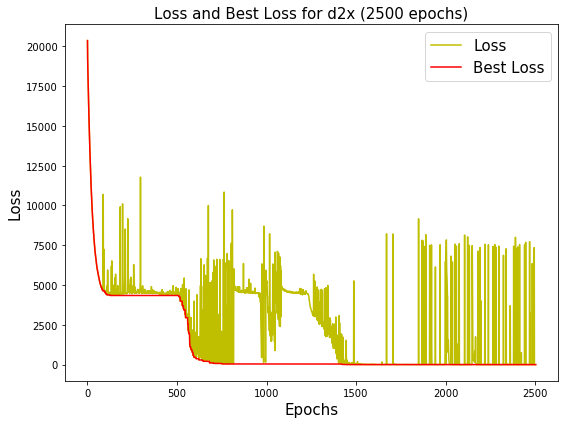

In [177]:
plot_helper(d2x_loss, d2x_best_loss, 'd2x (2500 epochs)', '../figures/d2x_2500.png')

## Batch 3 (d3x)

In [178]:
d3x_loss, d3x_best_loss, d3x_e_done, d3x_min_loss = [], [], 0, 10e10

#### After 1000 epochs

In [180]:
l, bl, d3x_e_done, d3x_min_loss = train_helper(
    model=model, 
    X=d3x, y=d3y, 
    epochs=1000, log_at=100, epochs_done=d3x_e_done,
    loss_min=d3x_min_loss,
    save_path="../models/03_arch_d3x")

d3x_loss.extend(l)
d3x_best_loss.extend(bl)

Epoch: 0, current_loss: 784150.8779860276, best_loss: 784150.8779860276
Epoch: 100, current_loss: 526612.4219196027, best_loss: 526612.4219196027
Epoch: 200, current_loss: 371576.4985926151, best_loss: 371576.4985926151
Epoch: 300, current_loss: 276157.40616356407, best_loss: 276157.40616356407
Epoch: 400, current_loss: 221252.91377443884, best_loss: 221252.91377443884
Epoch: 500, current_loss: 189963.55000341855, best_loss: 189963.55000341855
Epoch: 600, current_loss: 173472.36828284996, best_loss: 173472.36828284996
Epoch: 700, current_loss: 167475.46688030317, best_loss: 165722.12767701645
Epoch: 800, current_loss: 161921.39756473555, best_loss: 161921.39756473555
Epoch: 900, current_loss: 160664.32074038914, best_loss: 160663.22481757402
Epoch: 1000, current_loss: 160836.15451621093, best_loss: 160538.55127274015


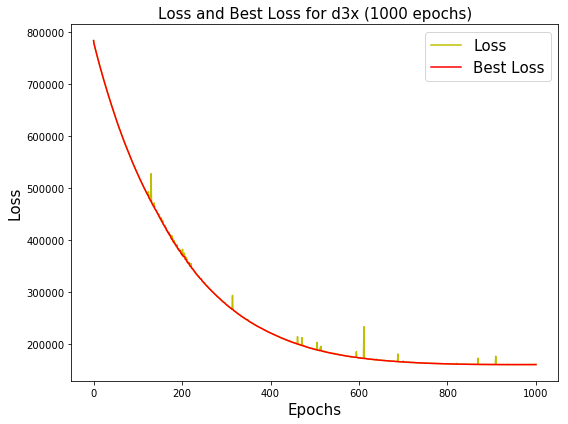

In [181]:
plot_helper(d3x_loss, d3x_best_loss, 'd3x (1000 epochs)', '../figures/d3x_1000.png')

#### After 6000 epochs

In [194]:
l, bl, d3x_e_done, d3x_min_loss = train_helper(
    model=model, 
    X=d3x, y=d3y, 
    epochs=2000, log_at=100, epochs_done=d3x_e_done,
    loss_min=d3x_min_loss,
    save_path="../models/03_arch_d3x")

d3x_loss.extend(l)
d3x_best_loss.extend(bl)

Epoch: 4000, current_loss: 6.817868268260589, best_loss: 4.070477033463808
Epoch: 4100, current_loss: 5.123243107245519, best_loss: 3.102847398473666
Epoch: 4200, current_loss: 4.7875750838563995, best_loss: 2.397874190257146
Epoch: 4300, current_loss: 7.559802378599461, best_loss: 0.7662868126868628
Epoch: 4400, current_loss: 7.698817676076522, best_loss: 0.7662868126868628
Epoch: 4500, current_loss: 2.9454841625231962, best_loss: 0.4587669359870443
Epoch: 4600, current_loss: 2.494176515754169, best_loss: 0.4587669359870443
Epoch: 4700, current_loss: 1.991158493866141, best_loss: 0.4587669359870443
Epoch: 4800, current_loss: 3.984342838709171, best_loss: 0.4236574511204918
Epoch: 4900, current_loss: 1.3795154123352125, best_loss: 0.4004909944219085
Epoch: 5000, current_loss: 1.5988498261341682, best_loss: 0.35031771188816774
Epoch: 5100, current_loss: 1.0996696224006324, best_loss: 0.3414852771048362
Epoch: 5200, current_loss: 0.44257276892088926, best_loss: 0.272310551846973
Epoch: 5

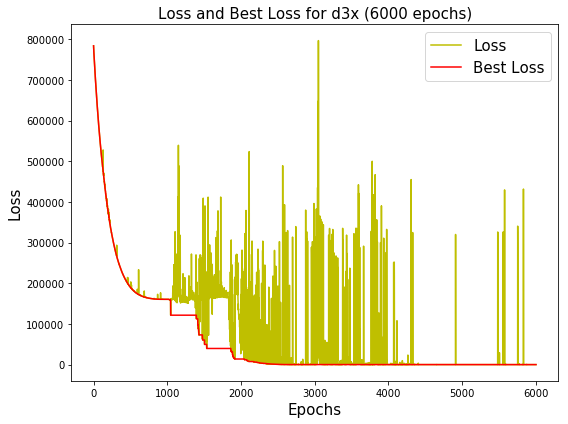

In [195]:
plot_helper(d3x_loss, d3x_best_loss, 'd3x (6000 epochs)', '../figures/d3x_6000.png')

### All losses together

def plot_helper(l, bl, name, save_path):
    x_scale = range(len(l))
    plt.clf()
    plt.figure(figsize=[8, 6])
    plt.subplot(111)
    plt.plot(x_scale, l, 'y-', label='Loss')
    plt.plot(x_scale, bl, 'r-', label='Best Loss')
    plt.title('Loss and Best Loss for ' + name, fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.savefig(save_path)

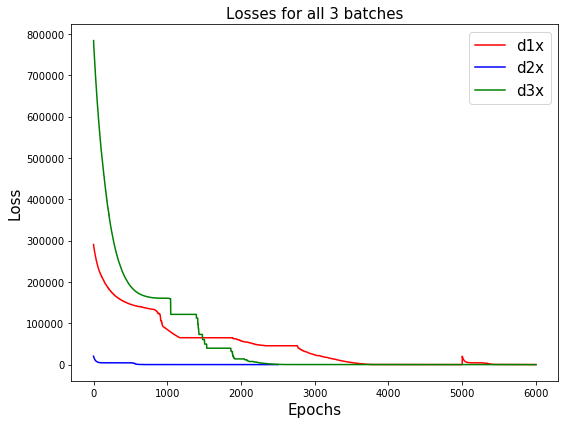

In [202]:
plt.clf()
plt.figure(figsize=[8, 6])
plt.subplot(111)
plt.plot(range(len(d1x_best_loss)), d1x_best_loss, 'r-', label='d1x')
plt.plot(range(len(d2x_best_loss)), d2x_best_loss, 'b-', label='d2x')
plt.plot(range(len(d3x_best_loss)), d3x_best_loss, 'g-', label='d3x')
plt.title('Losses for all 3 batches', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("../figures/03_arch_all_losses.png")

## Time for prediction!!

In [296]:
model = load_model("../models/03_arch_d2x")

Say I like the movies:
    1. Spiderman
    2. Captain America
    3. Batman v Superman
    
These have movieId's 163, 23, and 44 respectively
    

In [302]:
movie_id = np.array([163, 23, 44])
movie_id = movie_id.reshape(movie_id.shape[0], 1, 1)

In [303]:
model.reset_states()
pred = model.predict(movie_id, batch_size=1)
pred = np.array(pred, dtype='int')

In [304]:
pred = pred.reshape((3, ))
pred

array([25, 12,  9])

In [311]:
data = pd.read_csv("../data/movie_metadata.csv")

In [306]:
data.loc[pred, :].movie_title

25        The Amazing Spider-Man 
12    Captain America: Civil War 
9                   Spider-Man 3 
Name: movie_title, dtype: object

These movies correspond to:
    1. The Amazing siper man
    2. Batman vs superman
    3. Spider man 3

In [307]:
movie_id = np.array([82, 23, 44])
movie_id = movie_id.reshape(movie_id.shape[0], 1, 1)
model.reset_states()
pred = model.predict(movie_id, batch_size=1)
pred = np.array(pred, dtype='int')
pred = pred.reshape((3, ))
data.loc[pred, :].movie_title

24          Iron Man 3 
11    Superman Returns 
9         Spider-Man 3 
Name: movie_title, dtype: object

In [312]:
movie_id = np.array([44, 163, 23])
movie_id = movie_id.reshape(movie_id.shape[0], 1, 1)
model.reset_states()
pred = model.predict(movie_id, batch_size=1)
pred = np.array(pred, dtype='int')
pred = pred.reshape((3, ))
data.loc[pred, :].movie_title

20    Man of Steel 
17    The Avengers 
19      Iron Man 3 
Name: movie_title, dtype: object